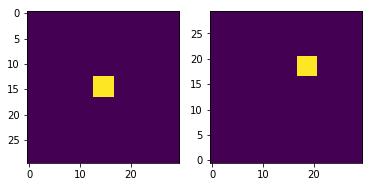

In [13]:
import numpy as np

constant = np.zeros((30,30), np.float32)
constant[13:17,13:17] = np.ones((4,4), np.float32)

measurement = np.zeros((30,30), np.float32)
measurement[17:21,17:21] = np.ones((4,4), np.float32)

from matplotlib import pyplot as plt
#grid with one row, two columns and the index is 1 in this grid
plt.subplot(121)
plt.imshow(constant)
#grid with one row, two columns and the index is 2 in this grid
plt.subplot(122)
plt.imshow(measurement)
plt.gca().invert_yaxis()
plt.show()

In [100]:
x = np.array([0,0]) #the displacement
def f(constant_value, x):
    measurement_estimated = np.zeros(constant_value.shape, np.float32)
    x_ = int(x[0])
    y_ = int(x[1])
    #print "x_", x_, "y_", y_
    for i in range(constant_value.shape[0]):
        for j in range(constant_value.shape[1]):    
            i_idx = max(0, min(constant_value.shape[0]-1, i-y_))
            j_idx = max(0, min(constant_value.shape[1]-1, j-x_))
            measurement_estimated[i,j] = constant_value[i_idx,j_idx]
    return measurement_estimated

m =f(constant, x)

In [101]:
from scipy import signal
def computeJmatrix(measurement, x):
    #unreferenced parameter x
    x_op = np.array([[ -1, 0, 1],
                       [ -1, 0, 1],
                       [ -1, 0, 1]])
    y_op = x_op.T
    grad_x = signal.convolve2d(measurement, x_op, boundary='symm', mode='same')
    grad_y = signal.convolve2d(measurement, y_op, boundary='symm', mode='same')
    n = measurement.shape[0] * measurement.shape[1]
    J = np.zeros((n, 2))
    J[:,0] = grad_x.flatten()
    J[:,1] = grad_y.flatten()
    return J

def computeJTensor(measurement, x):
    #unreferenced parameter x
    x_op = np.array([[ -1, 0, 1],
                       [ -1, 0, 1],
                       [ -1, 0, 1]])
    y_op = x_op.T
    grad_x = signal.convolve2d(measurement, x_op, boundary='symm', mode='same')
    grad_y = signal.convolve2d(measurement, y_op, boundary='symm', mode='same')
    n = measurement.shape[0] * measurement.shape[1]
    J = np.zeros((2, measurement.shape[0], measurement.shape[1]))
    J[0,...] = grad_x
    J[0,...] = grad_y
    return J

J_m = computeJmatrix(measurement, x)
J_t = computeJTensor(measurement, x)

In [102]:
def computeDXmatrix(J, constant_value, fx):
    dx = (J.T.dot(J))
    #print "dx computeDXmatrix",dx
    dx = np.linalg.inv(dx)
    dx = dx.dot(J.T)
    difference = constant_value -fx
    dx = dx.dot(difference.flatten())
    return dx

def computeDXtensor(J, constant_value, fx):
    #J has shape   2xNxM
    #J.T has shape MxNx2
    #I want output shape 2x2
    #https://docs.scipy.org/doc/numpy/reference/generated/numpy.tensordot.html#numpy.tensordot
    # I want the summation to be on axis 1 and 2 in order to reduce them
    #dx = np.tensordot(J.T,J,axes=([1,0],[1,2]))
    dx = np.tensordot(J,J,axes=([2 ,1],[2, 1]))
    #print "dx computeDXtensor",dx
    dx = np.linalg.inv(dx)
    dx = dx.dot(J.T)
    difference = constant_value -fx
    dx = dx.dot(difference.flatten())
    return dx

fx = f(constant, x)
dx = computeDXmatrix(J_m, constant, fx)
#dx = computeDXtensor(J_t, constant, fx)

In [125]:
def optimise(constant_value, measurement, alpha = 1.0):
    x0 = np.array([0,0], np.float32)
    for i in range(10):
        J = computeJmatrix(measurement, x0)
        fx = f(constant_value, x0)
        dx = computeDX(J, measurement, fx)
        x0 += dx * alpha
        E = measurement - fx
        if np.sum(np.abs(E)) <2:
            #print "broke at ", i
            break
    return x0

import time

start = time.time()
for i in range(1000):
    x0 = optimise(constant, measurement,alpha = 50.0)
end = time.time()
print(end - start)
print x0

5.04000020027
[4.017857 4.017857]
